<a href="https://colab.research.google.com/github/ndahlquist/pytorch-fourier-feature-networks/blob/notebook/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import urllib.request

import torch

import torch.nn as nn
import tqdm

import numpy as np
import cv2

import cv2
import imageio
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
from torch import nn
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


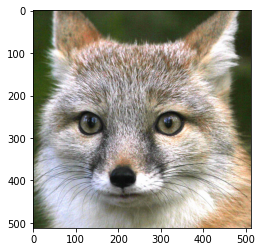

In [ ]:
def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor

def get_image():
    image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
    img = imageio.imread(image_url)[..., :3] / 255.
    c = [img.shape[0] // 2, img.shape[1] // 2]
    r = 256
    img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]

    return img


img = torch.tensor(get_image()).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(img[0]))
plt.show()

In [ ]:
class GaussianFourierFeatureTransform(torch.nn.Module):
    """
    An implementation of Gaussian Fourier feature mapping.

    "Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains":
       https://arxiv.org/abs/2006.10739
       https://people.eecs.berkeley.edu/~bmild/fourfeat/index.html

    Given an input of size [batches, num_input_channels, width, height],
     returns a tensor of size [batches, mapping_size*2, width, height].
    """

    def __init__(self, num_input_channels, mapping_size=256, scale=10):
        super().__init__()

        self._num_input_channels = num_input_channels
        self._mapping_size = mapping_size
        self._B = torch.randn((num_input_channels, mapping_size)) * scale

    def forward(self, x):
        assert x.dim() == 4, 'Expected 4D input (got {}D input)'.format(x.dim())

        batches, channels, width, height = x.shape

        assert channels == self._num_input_channels,\
            "Expected input to have {} channels (got {} channels)".format(self._num_input_channels, channels)

        # Make shape compatible for matmul with _B.
        # From [B, C, W, H] to [(B*W*H), C].
        x = x.permute(0, 2, 3, 1).reshape(batches * width * height, channels)

        x = x @ self._B.to(x.device)

        # From [(B*W*H), C] to [B, W, H, C]
        x = x.view(batches, width, height, self._mapping_size)
        # From [B, W, H, C] to [B, C, W, H]
        x = x.permute(0, 3, 1, 2)

        x = 2 * pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

0.24161966300169416


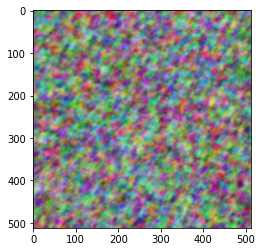

0.07212528879753367


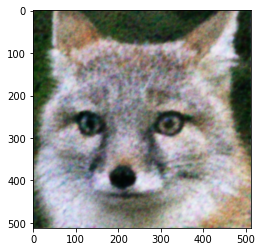

0.05291223554663799


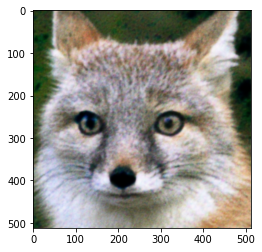

KeyboardInterrupt: ignored

In [ ]:
model = nn.Sequential(
        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            3,
            kernel_size=1,
            padding=0),
        nn.Sigmoid(),

    ).to(device)


# Create input pixel coordinates in the unit square
coords = np.linspace(0, 1, img.shape[2], endpoint=False)
x = np.stack(np.meshgrid(coords, coords), -1)
x = torch.tensor(x).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

x = GaussianFourierFeatureTransform(2, 128, 10)(x)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

for epoch in tqdm(range(1000)):
    optimizer.zero_grad()

    generated = model(x)

    loss = torch.nn.functional.l1_loss(img, generated)

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print(float(loss))
      plt.imshow(tensor_to_numpy(generated[0]))
      plt.show()

